In [2]:
import h5py
import numpy as np
import optuna
import pandas as pd
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from verstack import LGBMTuner

from dataset import EnergyDataset
from model import LightningFullyConnected

DATA_DIR = "/home/amh/Documents/Coding/GitHub/AppliedML2023/data/initial"

2023-05-21 12:34:14.592251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 12:34:16.212144: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-21 12:34:16.212279: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-21 12:34:16.212291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
all_data = EnergyDataset()
features, labels = all_data[:]
features = pd.DataFrame(features.detach().numpy(), columns=all_data.variables)
labels = pd.Series(labels.detach().numpy())

In [4]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        filename = name.split('/')[-1]
        return pd.DataFrame(f[filename][:], dtype=np.float32)

train = load_data(f'{DATA_DIR}/train')
test  = load_data(f'{DATA_DIR}/test')

all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

electrons = train['Truth']

opt_features = ['p_deltaEta2', 'p_EptRatio', 'p_deltaPhiRescaled2', 'p_deltaEta1', 'p_deltaPhi2', 'p_pt_track', 'p_qOverP', 'p_d0', 'p_eCluster', 'p_Rphi', 'p_sigmad0', 'p_d0Sig', 'p_nCells_Lr1_HiG', 'p_ptconecoreTrackPtrCorrection', 'p_deltaPhiFromLastMeasurement', 'p_nCells_Lr2_HiG', 'p_weta1', 'p_Reta', 'p_deltaPhi1', 'p_weta2']

X = train[opt_features][electrons == 1]
y = train["p_truth_E"][electrons == 1]

In [30]:
def rel_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred / y_true))

def objective(trial: optuna.Trial, feature_values, target_values, n_splits=5) -> float:
    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "verbose": False,
        "task_type": "GPU",
    }
    cat_reg = CatBoostRegressor(**params)
    total_rel_mae = 0.
    skf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, val_index in skf.split(feature_values, target_values):
        X_train = feature_values.iloc[train_index]
        X_val = feature_values.iloc[val_index]
        y_train = target_values.iloc[train_index]
        y_val = target_values.iloc[val_index]
        cat_reg.fit(X_train, y_train)
        total_rel_mae += rel_mae(y_val, cat_reg.predict(X_val))
    return total_rel_mae / n_splits

cat_study = optuna.create_study(direction="minimize")
optuna.logging.set_verbosity(optuna.logging.INFO)
cat_study.optimize(lambda t: objective(t, X, y), n_trials=200)

[I 2023-05-21 11:54:52,353] A new study created in memory with name: no-name-6c76c253-3aec-4dd7-a7b5-cf9017ac42e9
[I 2023-05-21 11:55:08,764] Trial 0 finished with value: 146572.1309369902 and parameters: {'iterations': 607, 'learning_rate': 0.0010873411454867955, 'depth': 9, 'l2_leaf_reg': 1.7762750778480325, 'bootstrap_type': 'Bayesian', 'random_strength': 0.4919521126096259, 'bagging_temperature': 1.8520786156775193, 'od_type': 'Iter', 'od_wait': 45}. Best is trial 0 with value: 146572.1309369902.
[I 2023-05-21 11:55:15,778] Trial 1 finished with value: 146572.17618464466 and parameters: {'iterations': 537, 'learning_rate': 0.009924904213262533, 'depth': 4, 'l2_leaf_reg': 1.3681245295774277e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0129162636113396, 'bagging_temperature': 8.031988072756803, 'od_type': 'Iter', 'od_wait': 13}. Best is trial 0 with value: 146572.1309369902.
[I 2023-05-21 11:55:31,745] Trial 2 finished with value: 146572.1839140976 and parameters: {'iterat

In [5]:
def rel_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred / y_true))

def lgbm_objective(trial: optuna.Trial, feature_values, target_values, n_splits=5):
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
        "metric": trial.suggest_categorical("metric", ["l1", "l2"]),
    }
    lgbm_regressor = LGBMRegressor(**param_grid)
    total_rel_mae = 0.
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, val_index in skf.split(feature_values, target_values):
        X_train = feature_values.iloc[train_index]
        X_val = feature_values.iloc[val_index]
        y_train = target_values.iloc[train_index]
        y_val = target_values.iloc[val_index]
        lgbm_regressor.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=100,
            verbose=False,
        )
        total_rel_mae += rel_mae(y_val, lgbm_regressor.predict(X_val))
    return total_rel_mae / n_splits

lgbm_study = optuna.create_study(direction="minimize")
optuna.logging.set_verbosity(optuna.logging.INFO)
lgbm_study.optimize(lambda t: lgbm_objective(t, X, y), n_trials=200)

[I 2023-05-21 12:38:52,483] A new study created in memory with name: no-name-f2c1cedc-b460-4cab-bd3b-37cdd90667e2


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.55977637422022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.55977637422022
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will 

[I 2023-05-21 12:43:10,112] Trial 0 finished with value: 146572.1814812509 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08834838193687124, 'num_leaves': 580, 'max_depth': 7, 'min_data_in_leaf': 9600, 'max_bin': 291, 'lambda_l1': 20, 'lambda_l2': 75, 'min_gain_to_split': 10.55977637422022, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7, 'metric': 'l1'}. Best is trial 0 with value: 146572.1814812509.


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.296629722764333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.296629722764333
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will 

[I 2023-05-21 12:46:30,034] Trial 1 finished with value: 146572.18277712268 and parameters: {'n_estimators': 10000, 'learning_rate': 0.095641593342859, 'num_leaves': 500, 'max_depth': 12, 'min_data_in_leaf': 2600, 'max_bin': 273, 'lambda_l1': 65, 'lambda_l2': 80, 'min_gain_to_split': 4.296629722764333, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l2'}. Best is trial 0 with value: 146572.1814812509.


[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.600732335792786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.600732335792786
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 wil

[I 2023-05-21 12:47:48,036] Trial 2 finished with value: 146572.17817345404 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13744727083052222, 'num_leaves': 2620, 'max_depth': 12, 'min_data_in_leaf': 9100, 'max_bin': 250, 'lambda_l1': 90, 'lambda_l2': 15, 'min_gain_to_split': 12.600732335792786, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'metric': 'l1'}. Best is trial 2 with value: 146572.17817345404.


[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=10.025446634350525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.025446634350525
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 wil

[I 2023-05-21 12:48:43,730] Trial 3 finished with value: 146572.17896151316 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2830539467880478, 'num_leaves': 2780, 'max_depth': 12, 'min_data_in_leaf': 7300, 'max_bin': 219, 'lambda_l1': 95, 'lambda_l2': 90, 'min_gain_to_split': 10.025446634350525, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7, 'metric': 'l1'}. Best is trial 2 with value: 146572.17817345404.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=1.6709736561582678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6709736561582678
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 wil

[I 2023-05-21 12:50:26,577] Trial 4 finished with value: 146572.17875384982 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04500182049890799, 'num_leaves': 1040, 'max_depth': 8, 'min_data_in_leaf': 6500, 'max_bin': 246, 'lambda_l1': 25, 'lambda_l2': 70, 'min_gain_to_split': 1.6709736561582678, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 2 with value: 146572.17817345404.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.201127742189926, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.201127742189926
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-21 12:53:06,682] Trial 5 finished with value: 146572.1798385626 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03592907663254673, 'num_leaves': 2980, 'max_depth': 6, 'min_data_in_leaf': 8900, 'max_bin': 272, 'lambda_l1': 20, 'lambda_l2': 95, 'min_gain_to_split': 5.201127742189926, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5, 'metric': 'l1'}. Best is trial 2 with value: 146572.17817345404.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.975047705575196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.975047705575196
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will 

[I 2023-05-21 12:56:12,109] Trial 6 finished with value: 146572.182879599 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09372586270419124, 'num_leaves': 1900, 'max_depth': 4, 'min_data_in_leaf': 6100, 'max_bin': 276, 'lambda_l1': 30, 'lambda_l2': 50, 'min_gain_to_split': 0.975047705575196, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8, 'metric': 'l2'}. Best is trial 2 with value: 146572.17817345404.


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=10.684675935239385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.684675935239385
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0

[I 2023-05-21 12:56:45,227] Trial 7 finished with value: 146572.18374317462 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2938483929266934, 'num_leaves': 1580, 'max_depth': 7, 'min_data_in_leaf': 2100, 'max_bin': 246, 'lambda_l1': 100, 'lambda_l2': 95, 'min_gain_to_split': 10.684675935239385, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5, 'metric': 'l1'}. Best is trial 2 with value: 146572.17817345404.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=12.865302102009187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.865302102009187
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-21 12:58:45,783] Trial 8 finished with value: 146572.18373883332 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01686546084644564, 'num_leaves': 2860, 'max_depth': 10, 'min_data_in_leaf': 900, 'max_bin': 291, 'lambda_l1': 20, 'lambda_l2': 25, 'min_gain_to_split': 12.865302102009187, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8, 'metric': 'l1'}. Best is trial 2 with value: 146572.17817345404.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=5.068686749419115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.068686749419115
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will 

[I 2023-05-21 13:00:20,704] Trial 9 finished with value: 146572.18140622665 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12966006125160456, 'num_leaves': 1480, 'max_depth': 5, 'min_data_in_leaf': 8000, 'max_bin': 295, 'lambda_l1': 50, 'lambda_l2': 25, 'min_gain_to_split': 5.068686749419115, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 2 with value: 146572.17817345404.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.719909981663386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.719909981663386
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 13:02:20,879] Trial 10 finished with value: 146572.17786069994 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21484305921908797, 'num_leaves': 2340, 'max_depth': 10, 'min_data_in_leaf': 4500, 'max_bin': 202, 'lambda_l1': 75, 'lambda_l2': 0, 'min_gain_to_split': 14.719909981663386, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9, 'metric': 'l2'}. Best is trial 10 with value: 146572.17786069994.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.948854897275035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.948854897275035
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 13:05:05,160] Trial 11 finished with value: 146572.17801522822 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2053148583494585, 'num_leaves': 2240, 'max_depth': 10, 'min_data_in_leaf': 4300, 'max_bin': 205, 'lambda_l1': 80, 'lambda_l2': 0, 'min_gain_to_split': 14.948854897275035, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9, 'metric': 'l2'}. Best is trial 10 with value: 146572.17786069994.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.480990585337548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.480990585337548
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 13:07:46,224] Trial 12 finished with value: 146572.17727609383 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2115594253212395, 'num_leaves': 2200, 'max_depth': 9, 'min_data_in_leaf': 4600, 'max_bin': 202, 'lambda_l1': 70, 'lambda_l2': 0, 'min_gain_to_split': 14.480990585337548, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9, 'metric': 'l2'}. Best is trial 12 with value: 146572.17727609383.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.6935419978298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.6935419978298
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be i

[I 2023-05-21 13:10:06,830] Trial 13 finished with value: 146572.17850684785 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21529129859781698, 'num_leaves': 2240, 'max_depth': 9, 'min_data_in_leaf': 4100, 'max_bin': 200, 'lambda_l1': 60, 'lambda_l2': 0, 'min_gain_to_split': 14.6935419978298, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7, 'metric': 'l2'}. Best is trial 12 with value: 146572.17727609383.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=8.607743724602544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.607743724602544
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 13:11:54,912] Trial 14 finished with value: 146572.18055664538 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21159626762193712, 'num_leaves': 2260, 'max_depth': 10, 'min_data_in_leaf': 4900, 'max_bin': 224, 'lambda_l1': 75, 'lambda_l2': 50, 'min_gain_to_split': 8.607743724602544, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9, 'metric': 'l2'}. Best is trial 12 with value: 146572.17727609383.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=12.633934415246943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.633934415246943
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-21 13:12:40,811] Trial 15 finished with value: 146572.18193932562 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2465906664851029, 'num_leaves': 1800, 'max_depth': 9, 'min_data_in_leaf': 3100, 'max_bin': 222, 'lambda_l1': 0, 'lambda_l2': 15, 'min_gain_to_split': 12.633934415246943, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8, 'metric': 'l2'}. Best is trial 12 with value: 146572.17727609383.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.861600975637058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.861600975637058
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-21 13:14:06,455] Trial 16 finished with value: 146572.1742347197 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17532660645171283, 'num_leaves': 1120, 'max_depth': 11, 'min_data_in_leaf': 5900, 'max_bin': 213, 'lambda_l1': 45, 'lambda_l2': 35, 'min_gain_to_split': 7.861600975637058, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'metric': 'l2'}. Best is trial 16 with value: 146572.1742347197.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=7.0139375396353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.0139375396353
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is 

[I 2023-05-21 13:16:07,954] Trial 17 finished with value: 146572.17881631906 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16044122657093363, 'num_leaves': 1060, 'max_depth': 3, 'min_data_in_leaf': 6000, 'max_bin': 234, 'lambda_l1': 45, 'lambda_l2': 40, 'min_gain_to_split': 7.0139375396353, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l2'}. Best is trial 16 with value: 146572.1742347197.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=2.964752373247057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.964752373247057
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-21 13:17:08,264] Trial 18 finished with value: 146572.18240694067 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17689381138397514, 'num_leaves': 200, 'max_depth': 11, 'min_data_in_leaf': 3400, 'max_bin': 216, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 2.964752373247057, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'metric': 'l2'}. Best is trial 16 with value: 146572.1742347197.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=7.160998663434151, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.160998663434151
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 13:17:40,676] Trial 19 finished with value: 146572.18371489047 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2523081501547482, 'num_leaves': 1280, 'max_depth': 8, 'min_data_in_leaf': 1400, 'max_bin': 233, 'lambda_l1': 60, 'lambda_l2': 60, 'min_gain_to_split': 7.160998663434151, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l2'}. Best is trial 16 with value: 146572.1742347197.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=8.999274684978495, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.999274684978495
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightG

[I 2023-05-21 13:19:24,475] Trial 20 finished with value: 146572.17931310055 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1870886129392076, 'num_leaves': 820, 'max_depth': 11, 'min_data_in_leaf': 5700, 'max_bin': 209, 'lambda_l1': 50, 'lambda_l2': 15, 'min_gain_to_split': 8.999274684978495, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'metric': 'l2'}. Best is trial 16 with value: 146572.1742347197.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.553675528061397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.553675528061397
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 13:20:39,861] Trial 21 finished with value: 146572.17676989702 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2466475762661035, 'num_leaves': 2480, 'max_depth': 9, 'min_data_in_leaf': 5000, 'max_bin': 209, 'lambda_l1': 75, 'lambda_l2': 5, 'min_gain_to_split': 13.553675528061397, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8, 'metric': 'l2'}. Best is trial 16 with value: 146572.1742347197.


[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.68951482402164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.68951482402164
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 13:20:57,431] Trial 22 finished with value: 146572.16907597374 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24703327224305194, 'num_leaves': 1960, 'max_depth': 9, 'min_data_in_leaf': 7300, 'max_bin': 212, 'lambda_l1': 85, 'lambda_l2': 25, 'min_gain_to_split': 11.68951482402164, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8, 'metric': 'l2'}. Best is trial 22 with value: 146572.16907597374.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.670908649953098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.670908649953098
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 13:21:14,837] Trial 23 finished with value: 146572.16955188382 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25296155757465827, 'num_leaves': 1880, 'max_depth': 11, 'min_data_in_leaf': 7000, 'max_bin': 229, 'lambda_l1': 40, 'lambda_l2': 30, 'min_gain_to_split': 11.670908649953098, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7, 'metric': 'l2'}. Best is trial 22 with value: 146572.16907597374.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=11.616149204525332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.616149204525332
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[Ligh

[I 2023-05-21 13:23:49,037] Trial 24 finished with value: 146572.17679093135 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2635323257112192, 'num_leaves': 1880, 'max_depth': 11, 'min_data_in_leaf': 7300, 'max_bin': 233, 'lambda_l1': 40, 'lambda_l2': 35, 'min_gain_to_split': 11.616149204525332, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'metric': 'l2'}. Best is trial 22 with value: 146572.16907597374.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=8.518286723319008, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.518286723319008
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will 

[I 2023-05-21 13:27:01,989] Trial 25 finished with value: 146572.17945273157 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27226833735343486, 'num_leaves': 1600, 'max_depth': 11, 'min_data_in_leaf': 7900, 'max_bin': 227, 'lambda_l1': 55, 'lambda_l2': 30, 'min_gain_to_split': 8.518286723319008, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7, 'metric': 'l2'}. Best is trial 22 with value: 146572.16907597374.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=9.672931745027368, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.672931745027368
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is se

[I 2023-05-21 13:29:35,602] Trial 26 finished with value: 146572.1830599526 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2318107814496887, 'num_leaves': 1240, 'max_depth': 11, 'min_data_in_leaf': 7000, 'max_bin': 215, 'lambda_l1': 0, 'lambda_l2': 45, 'min_gain_to_split': 9.672931745027368, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'metric': 'l2'}. Best is trial 22 with value: 146572.16907597374.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.474064778848327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.474064778848327
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 13:30:18,949] Trial 27 finished with value: 146572.1655677461 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18227018512933812, 'num_leaves': 1960, 'max_depth': 8, 'min_data_in_leaf': 8300, 'max_bin': 254, 'lambda_l1': 10, 'lambda_l2': 25, 'min_gain_to_split': 11.474064778848327, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5, 'metric': 'l2'}. Best is trial 27 with value: 146572.1655677461.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=11.666551335962554, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.666551335962554
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-21 13:33:11,420] Trial 28 finished with value: 146572.17552806632 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29957375386564555, 'num_leaves': 2040, 'max_depth': 6, 'min_data_in_leaf': 8300, 'max_bin': 255, 'lambda_l1': 5, 'lambda_l2': 20, 'min_gain_to_split': 11.666551335962554, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.5, 'metric': 'l2'}. Best is trial 27 with value: 146572.1655677461.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.09430804037778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.09430804037778
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 13:34:01,784] Trial 29 finished with value: 146572.15997840598 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12079142872798365, 'num_leaves': 1760, 'max_depth': 8, 'min_data_in_leaf': 9700, 'max_bin': 258, 'lambda_l1': 10, 'lambda_l2': 55, 'min_gain_to_split': 11.09430804037778, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7, 'metric': 'l2'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=10.9711107218279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.9711107218279
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will 

[I 2023-05-21 13:41:56,541] Trial 30 finished with value: 146572.17889663164 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11871507909091404, 'num_leaves': 1640, 'max_depth': 7, 'min_data_in_leaf': 10000, 'max_bin': 262, 'lambda_l1': 10, 'lambda_l2': 65, 'min_gain_to_split': 10.9711107218279, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l2'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.661236946541527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.661236946541527
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 13:42:58,662] Trial 31 finished with value: 146572.16213717993 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15023197126175497, 'num_leaves': 1980, 'max_depth': 8, 'min_data_in_leaf': 9200, 'max_bin': 263, 'lambda_l1': 10, 'lambda_l2': 55, 'min_gain_to_split': 11.661236946541527, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7, 'metric': 'l2'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=13.301883030433142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.301883030433142
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 13:45:46,220] Trial 32 finished with value: 146572.17315256974 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0720254927468541, 'num_leaves': 2040, 'max_depth': 8, 'min_data_in_leaf': 9300, 'max_bin': 264, 'lambda_l1': 10, 'lambda_l2': 55, 'min_gain_to_split': 13.301883030433142, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7, 'metric': 'l2'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=9.859460452804147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.859460452804147
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 13:46:03,967] Trial 33 finished with value: 146572.16466058767 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1484131525277737, 'num_leaves': 2580, 'max_depth': 6, 'min_data_in_leaf': 8600, 'max_bin': 281, 'lambda_l1': 10, 'lambda_l2': 80, 'min_gain_to_split': 9.859460452804147, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8, 'metric': 'l2'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=9.757564240844165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.757564240844165
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will 

[I 2023-05-21 13:48:05,290] Trial 34 finished with value: 146572.1784286846 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1506433479324924, 'num_leaves': 2540, 'max_depth': 6, 'min_data_in_leaf': 8600, 'max_bin': 284, 'lambda_l1': 15, 'lambda_l2': 80, 'min_gain_to_split': 9.757564240844165, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7, 'metric': 'l2'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.53742128089928, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.53742128089928
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 13:48:24,567] Trial 35 finished with value: 146573.28021345744 and parameters: {'n_estimators': 10000, 'learning_rate': 0.111737355397697, 'num_leaves': 2660, 'max_depth': 7, 'min_data_in_leaf': 9800, 'max_bin': 259, 'lambda_l1': 10, 'lambda_l2': 75, 'min_gain_to_split': 10.53742128089928, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5, 'metric': 'l2'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=6.175930219344253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.175930219344253
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 13:49:27,010] Trial 36 finished with value: 146572.1730029197 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14666678047406997, 'num_leaves': 1360, 'max_depth': 5, 'min_data_in_leaf': 9400, 'max_bin': 269, 'lambda_l1': 25, 'lambda_l2': 85, 'min_gain_to_split': 6.175930219344253, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8, 'metric': 'l2'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.792121634557766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.792121634557766
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 13:49:41,170] Trial 37 finished with value: 146572.1635759086 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07789912236394458, 'num_leaves': 1700, 'max_depth': 8, 'min_data_in_leaf': 8800, 'max_bin': 283, 'lambda_l1': 15, 'lambda_l2': 65, 'min_gain_to_split': 13.792121634557766, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=13.88890651454646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.88890651454646
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 13:50:10,493] Trial 38 finished with value: 146572.17629119725 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0660160211908796, 'num_leaves': 1720, 'max_depth': 7, 'min_data_in_leaf': 8900, 'max_bin': 285, 'lambda_l1': 25, 'lambda_l2': 70, 'min_gain_to_split': 13.88890651454646, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=12.432250425059872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.432250425059872
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 13:51:00,152] Trial 39 finished with value: 146572.18044208325 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10802248126464234, 'num_leaves': 1440, 'max_depth': 6, 'min_data_in_leaf': 9500, 'max_bin': 282, 'lambda_l1': 15, 'lambda_l2': 60, 'min_gain_to_split': 12.432250425059872, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=10.312563056022066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.312563056022066
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 13:51:28,964] Trial 40 finished with value: 146572.1746628261 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07517651322085807, 'num_leaves': 780, 'max_depth': 5, 'min_data_in_leaf': 7800, 'max_bin': 277, 'lambda_l1': 30, 'lambda_l2': 100, 'min_gain_to_split': 10.312563056022066, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=9.264966580915736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.264966580915736
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 13:51:38,912] Trial 41 finished with value: 146572.164812227 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12443053587775901, 'num_leaves': 2420, 'max_depth': 8, 'min_data_in_leaf': 8500, 'max_bin': 250, 'lambda_l1': 15, 'lambda_l2': 55, 'min_gain_to_split': 9.264966580915736, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5, 'metric': 'l1'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=9.50289174530308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.50289174530308
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be

[I 2023-05-21 13:51:49,131] Trial 42 finished with value: 146572.16409991958 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1299900031510224, 'num_leaves': 2380, 'max_depth': 8, 'min_data_in_leaf': 8700, 'max_bin': 242, 'lambda_l1': 15, 'lambda_l2': 55, 'min_gain_to_split': 9.50289174530308, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5, 'metric': 'l1'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.371990485173221, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.371990485173221
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be

[I 2023-05-21 13:52:02,304] Trial 43 finished with value: 146572.1631414046 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09179661152261769, 'num_leaves': 2760, 'max_depth': 8, 'min_data_in_leaf': 8900, 'max_bin': 242, 'lambda_l1': 5, 'lambda_l2': 70, 'min_gain_to_split': 12.371990485173221, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=12.381683181531987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.381683181531987
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-21 13:52:59,540] Trial 44 finished with value: 146572.17286094607 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0946861831345713, 'num_leaves': 3000, 'max_depth': 8, 'min_data_in_leaf': 9000, 'max_bin': 242, 'lambda_l1': 0, 'lambda_l2': 70, 'min_gain_to_split': 12.381683181531987, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 29 with value: 146572.15997840598.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.747416362380328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.747416362380328
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 13:53:02,420] Trial 45 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13385944399905167, 'num_leaves': 2860, 'max_depth': 8, 'min_data_in_leaf': 10000, 'max_bin': 242, 'lambda_l1': 20, 'lambda_l2': 65, 'min_gain_to_split': 13.747416362380328, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.09722671185466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.09722671185466
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be i

[I 2023-05-21 13:53:04,185] Trial 46 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.039520008452919586, 'num_leaves': 2720, 'max_depth': 7, 'min_data_in_leaf': 9900, 'max_bin': 268, 'lambda_l1': 5, 'lambda_l2': 60, 'min_gain_to_split': 14.09722671185466, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=13.063745840028675, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.063745840028675
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will 

[I 2023-05-21 13:53:53,441] Trial 47 finished with value: 146572.17479112366 and parameters: {'n_estimators': 10000, 'learning_rate': 0.038990514419937, 'num_leaves': 2800, 'max_depth': 7, 'min_data_in_leaf': 10000, 'max_bin': 269, 'lambda_l1': 5, 'lambda_l2': 65, 'min_gain_to_split': 13.063745840028675, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=14.373517780688031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.373517780688031
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-21 13:54:38,387] Trial 48 finished with value: 146572.1707841445 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019986560127115915, 'num_leaves': 2720, 'max_depth': 9, 'min_data_in_leaf': 9500, 'max_bin': 239, 'lambda_l1': 5, 'lambda_l2': 45, 'min_gain_to_split': 14.373517780688031, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.12720783989405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.12720783989405
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 13:54:55,569] Trial 49 finished with value: 146572.16180085458 and parameters: {'n_estimators': 10000, 'learning_rate': 0.056456406180156106, 'num_leaves': 2800, 'max_depth': 7, 'min_data_in_leaf': 9200, 'max_bin': 249, 'lambda_l1': 20, 'lambda_l2': 75, 'min_gain_to_split': 14.12720783989405, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=13.994457438418532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.994457438418532
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 13:55:50,110] Trial 50 finished with value: 146572.18007380088 and parameters: {'n_estimators': 10000, 'learning_rate': 0.059312542929081856, 'num_leaves': 2840, 'max_depth': 7, 'min_data_in_leaf': 9600, 'max_bin': 249, 'lambda_l1': 20, 'lambda_l2': 60, 'min_gain_to_split': 13.994457438418532, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.28442569178985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.28442569178985
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 13:56:10,245] Trial 51 finished with value: 146572.1622258717 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04938495347478071, 'num_leaves': 2920, 'max_depth': 7, 'min_data_in_leaf': 9100, 'max_bin': 256, 'lambda_l1': 25, 'lambda_l2': 75, 'min_gain_to_split': 12.28442569178985, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.105589663296758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.105589663296758
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 13:56:27,506] Trial 52 finished with value: 146572.16179967902 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05316831423194768, 'num_leaves': 2960, 'max_depth': 7, 'min_data_in_leaf': 9200, 'max_bin': 255, 'lambda_l1': 25, 'lambda_l2': 75, 'min_gain_to_split': 13.105589663296758, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.190913088871714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.190913088871714
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 w

[I 2023-05-21 13:56:28,901] Trial 53 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.029781483601108525, 'num_leaves': 3000, 'max_depth': 7, 'min_data_in_leaf': 10000, 'max_bin': 265, 'lambda_l1': 30, 'lambda_l2': 85, 'min_gain_to_split': 13.190913088871714, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=13.136946470084204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.136946470084204
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 13:57:37,992] Trial 54 finished with value: 146572.16960056283 and parameters: {'n_estimators': 10000, 'learning_rate': 0.012529094451475334, 'num_leaves': 2920, 'max_depth': 6, 'min_data_in_leaf': 10000, 'max_bin': 267, 'lambda_l1': 30, 'lambda_l2': 85, 'min_gain_to_split': 13.136946470084204, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.96656588433413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.96656588433413
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 13:58:00,673] Trial 55 finished with value: 146573.27790741128 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026490063541339592, 'num_leaves': 2660, 'max_depth': 6, 'min_data_in_leaf': 9800, 'max_bin': 274, 'lambda_l1': 35, 'lambda_l2': 90, 'min_gain_to_split': 14.96656588433413, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=14.140214746682721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.140214746682721
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 13:58:27,126] Trial 56 finished with value: 146572.17091751864 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05239401632339209, 'num_leaves': 2960, 'max_depth': 7, 'min_data_in_leaf': 9600, 'max_bin': 246, 'lambda_l1': 20, 'lambda_l2': 85, 'min_gain_to_split': 14.140214746682721, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.479865018394289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.479865018394289
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 13:58:50,961] Trial 57 finished with value: 146572.1655439477 and parameters: {'n_estimators': 10000, 'learning_rate': 0.034151154519547644, 'num_leaves': 2860, 'max_depth': 5, 'min_data_in_leaf': 8200, 'max_bin': 259, 'lambda_l1': 30, 'lambda_l2': 75, 'min_gain_to_split': 13.479865018394289, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=14.404325324390989, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.404325324390989
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 13:59:41,657] Trial 58 finished with value: 146572.17969157602 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02955693933661071, 'num_leaves': 2500, 'max_depth': 7, 'min_data_in_leaf': 7600, 'max_bin': 253, 'lambda_l1': 20, 'lambda_l2': 90, 'min_gain_to_split': 14.404325324390989, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.831274431304912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.831274431304912
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:00:03,457] Trial 59 finished with value: 146572.1614406061 and parameters: {'n_estimators': 10000, 'learning_rate': 0.042845821407571594, 'num_leaves': 2720, 'max_depth': 9, 'min_data_in_leaf': 9300, 'max_bin': 260, 'lambda_l1': 35, 'lambda_l2': 65, 'min_gain_to_split': 12.831274431304912, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=3.039239353987914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.039239353987914
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:00:19,588] Trial 60 finished with value: 146572.17039018692 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08202929523223879, 'num_leaves': 2160, 'max_depth': 9, 'min_data_in_leaf': 9700, 'max_bin': 260, 'lambda_l1': 40, 'lambda_l2': 60, 'min_gain_to_split': 3.039239353987914, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.945261592500746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.945261592500746
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:00:40,119] Trial 61 finished with value: 146572.16096749125 and parameters: {'n_estimators': 10000, 'learning_rate': 0.045993456512734086, 'num_leaves': 2720, 'max_depth': 9, 'min_data_in_leaf': 9400, 'max_bin': 251, 'lambda_l1': 35, 'lambda_l2': 75, 'min_gain_to_split': 12.945261592500746, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.861564163434542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.861564163434542
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:01:06,131] Trial 62 finished with value: 146572.16177117685 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03871866561650178, 'num_leaves': 2660, 'max_depth': 10, 'min_data_in_leaf': 9200, 'max_bin': 267, 'lambda_l1': 25, 'lambda_l2': 65, 'min_gain_to_split': 12.861564163434542, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.845670723046371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.845670723046371
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:01:07,401] Trial 63 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.039957766143480046, 'num_leaves': 2660, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 266, 'lambda_l1': 35, 'lambda_l2': 65, 'min_gain_to_split': 12.845670723046371, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.88201223031979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.88201223031979
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:01:08,736] Trial 64 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0418265529052004, 'num_leaves': 80, 'max_depth': 9, 'min_data_in_leaf': 10000, 'max_bin': 276, 'lambda_l1': 35, 'lambda_l2': 50, 'min_gain_to_split': 10.88201223031979, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.077493023076721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.077493023076721
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:01:09,950] Trial 65 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020961022700306906, 'num_leaves': 60, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 277, 'lambda_l1': 45, 'lambda_l2': 50, 'min_gain_to_split': 12.077493023076721, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=11.132709471502363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.132709471502363
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[

[I 2023-05-21 14:02:16,892] Trial 66 finished with value: 146572.1695963833 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010694485651244595, 'num_leaves': 120, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 289, 'lambda_l1': 45, 'lambda_l2': 45, 'min_gain_to_split': 11.132709471502363, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.083593347502987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.083593347502987
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:02:41,011] Trial 67 finished with value: 146572.15939228522 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023072396480629104, 'num_leaves': 160, 'max_depth': 10, 'min_data_in_leaf': 9700, 'max_bin': 277, 'lambda_l1': 55, 'lambda_l2': 50, 'min_gain_to_split': 12.083593347502987, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.009625964372136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.009625964372136
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:02:42,431] Trial 68 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06376342280888611, 'num_leaves': 360, 'max_depth': 12, 'min_data_in_leaf': 10000, 'max_bin': 298, 'lambda_l1': 55, 'lambda_l2': 50, 'min_gain_to_split': 12.009625964372136, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=12.022180659812364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.022180659812364
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[

[I 2023-05-21 14:03:13,183] Trial 69 finished with value: 146572.16988099198 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03148883260061834, 'num_leaves': 300, 'max_depth': 12, 'min_data_in_leaf': 10000, 'max_bin': 297, 'lambda_l1': 55, 'lambda_l2': 40, 'min_gain_to_split': 12.022180659812364, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=0.18100599918898386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.18100599918898386
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:03:40,692] Trial 70 finished with value: 146572.18425289314 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06421645505420556, 'num_leaves': 320, 'max_depth': 12, 'min_data_in_leaf': 200, 'max_bin': 292, 'lambda_l1': 45, 'lambda_l2': 50, 'min_gain_to_split': 0.18100599918898386, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.052173088640112, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.052173088640112
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:04:07,181] Trial 71 finished with value: 146572.15924405117 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017518007033279888, 'num_leaves': 500, 'max_depth': 10, 'min_data_in_leaf': 9700, 'max_bin': 278, 'lambda_l1': 65, 'lambda_l2': 50, 'min_gain_to_split': 12.052173088640112, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.533605546446553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.533605546446553
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:04:08,854] Trial 72 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023593201345452258, 'num_leaves': 420, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 273, 'lambda_l1': 70, 'lambda_l2': 45, 'min_gain_to_split': 13.533605546446553, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.599752045801782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.599752045801782
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 w

[I 2023-05-21 14:04:10,352] Trial 73 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024610208370473508, 'num_leaves': 260, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 273, 'lambda_l1': 50, 'lambda_l2': 45, 'min_gain_to_split': 13.599752045801782, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.646783821950622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.646783821950622
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:04:39,917] Trial 74 finished with value: 146572.18045787333 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0433440195013893, 'num_leaves': 700, 'max_depth': 11, 'min_data_in_leaf': 1800, 'max_bin': 273, 'lambda_l1': 70, 'lambda_l2': 40, 'min_gain_to_split': 13.646783821950622, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.68310079272553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.68310079272553
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:05:00,723] Trial 75 finished with value: 146572.17089246216 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06551443636762858, 'num_leaves': 300, 'max_depth': 12, 'min_data_in_leaf': 6400, 'max_bin': 270, 'lambda_l1': 50, 'lambda_l2': 35, 'min_gain_to_split': 14.68310079272553, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.492053000891906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.492053000891906
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0

[I 2023-05-21 14:05:36,327] Trial 76 finished with value: 146572.16039867094 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025531032900497012, 'num_leaves': 60, 'max_depth': 10, 'min_data_in_leaf': 9500, 'max_bin': 266, 'lambda_l1': 100, 'lambda_l2': 45, 'min_gain_to_split': 13.492053000891906, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.735063601405402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.735063601405402
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:06:06,125] Trial 77 finished with value: 146572.1629618407 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03278748555062431, 'num_leaves': 400, 'max_depth': 11, 'min_data_in_leaf': 8900, 'max_bin': 288, 'lambda_l1': 50, 'lambda_l2': 50, 'min_gain_to_split': 10.735063601405402, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=11.23695058807235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.23695058807235
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:06:52,476] Trial 78 finished with value: 146572.17320262626 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019657140581819055, 'num_leaves': 40, 'max_depth': 10, 'min_data_in_leaf': 8400, 'max_bin': 274, 'lambda_l1': 60, 'lambda_l2': 45, 'min_gain_to_split': 11.23695058807235, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=12.610102528483425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.610102528483425
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:07:29,085] Trial 79 finished with value: 146572.18056723825 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05953940958271259, 'num_leaves': 540, 'max_depth': 9, 'min_data_in_leaf': 5500, 'max_bin': 280, 'lambda_l1': 85, 'lambda_l2': 60, 'min_gain_to_split': 12.610102528483425, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=14.416733418331248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.416733418331248
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 wil

[I 2023-05-21 14:08:45,202] Trial 80 finished with value: 146572.18186826646 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08589255825667019, 'num_leaves': 640, 'max_depth': 9, 'min_data_in_leaf': 9700, 'max_bin': 271, 'lambda_l1': 40, 'lambda_l2': 40, 'min_gain_to_split': 14.416733418331248, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.541390955685388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.541390955685388
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:08:46,681] Trial 81 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010064113667144386, 'num_leaves': 920, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 264, 'lambda_l1': 40, 'lambda_l2': 55, 'min_gain_to_split': 13.541390955685388, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.28153275161325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.28153275161325
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:09:21,669] Trial 82 finished with value: 146573.26701723147 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011034385637183423, 'num_leaves': 220, 'max_depth': 10, 'min_data_in_leaf': 9800, 'max_bin': 300, 'lambda_l1': 40, 'lambda_l2': 55, 'min_gain_to_split': 13.28153275161325, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.854946447895452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.854946447895452
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:09:44,205] Trial 83 finished with value: 146572.17845560226 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03674359311900539, 'num_leaves': 920, 'max_depth': 9, 'min_data_in_leaf': 3000, 'max_bin': 265, 'lambda_l1': 30, 'lambda_l2': 55, 'min_gain_to_split': 13.854946447895452, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.508715921354916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.508715921354916
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:10:21,091] Trial 84 finished with value: 146572.16093607416 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02704275118653208, 'num_leaves': 220, 'max_depth': 10, 'min_data_in_leaf': 9400, 'max_bin': 279, 'lambda_l1': 35, 'lambda_l2': 45, 'min_gain_to_split': 13.508715921354916, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.905854535467512, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.905854535467512
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:11:59,110] Trial 85 finished with value: 146572.16250745166 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0200556428101208, 'num_leaves': 440, 'max_depth': 11, 'min_data_in_leaf': 9000, 'max_bin': 275, 'lambda_l1': 45, 'lambda_l2': 50, 'min_gain_to_split': 11.905854535467512, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=14.929884541772221, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.929884541772221
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:12:29,913] Trial 86 finished with value: 146572.17948827526 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10521996601327498, 'num_leaves': 380, 'max_depth': 11, 'min_data_in_leaf': 4000, 'max_bin': 263, 'lambda_l1': 65, 'lambda_l2': 60, 'min_gain_to_split': 14.929884541772221, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.24258029234946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.24258029234946
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:12:31,910] Trial 87 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1983419765935723, 'num_leaves': 120, 'max_depth': 12, 'min_data_in_leaf': 9900, 'max_bin': 287, 'lambda_l1': 55, 'lambda_l2': 35, 'min_gain_to_split': 10.24258029234946, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.252514689966757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.252514689966757
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:12:44,944] Trial 88 finished with value: 146572.16404086738 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16373919017095895, 'num_leaves': 80, 'max_depth': 12, 'min_data_in_leaf': 8700, 'max_bin': 286, 'lambda_l1': 50, 'lambda_l2': 30, 'min_gain_to_split': 10.252514689966757, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=8.032922728810224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.032922728810224
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:13:50,003] Trial 89 finished with value: 146572.18119948023 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22814717944794255, 'num_leaves': 200, 'max_depth': 12, 'min_data_in_leaf': 9800, 'max_bin': 293, 'lambda_l1': 55, 'lambda_l2': 35, 'min_gain_to_split': 8.032922728810224, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=10.661483159769752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.661483159769752
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:14:14,737] Trial 90 finished with value: 146572.17160623675 and parameters: {'n_estimators': 10000, 'learning_rate': 0.200131038260028, 'num_leaves': 260, 'max_depth': 12, 'min_data_in_leaf': 9400, 'max_bin': 297, 'lambda_l1': 60, 'lambda_l2': 30, 'min_gain_to_split': 10.661483159769752, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.068465211012935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.068465211012935
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:14:16,204] Trial 91 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.043760119199195056, 'num_leaves': 1180, 'max_depth': 11, 'min_data_in_leaf': 10000, 'max_bin': 268, 'lambda_l1': 70, 'lambda_l2': 70, 'min_gain_to_split': 14.068465211012935, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.394914763079175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.394914763079175
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 w

[I 2023-05-21 14:14:18,420] Trial 92 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19653525660741583, 'num_leaves': 460, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 271, 'lambda_l1': 45, 'lambda_l2': 40, 'min_gain_to_split': 11.394914763079175, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.776087440664936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.776087440664936
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:15:02,343] Trial 93 finished with value: 146572.16029953284 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01609955902959525, 'num_leaves': 20, 'max_depth': 10, 'min_data_in_leaf': 9500, 'max_bin': 272, 'lambda_l1': 55, 'lambda_l2': 45, 'min_gain_to_split': 12.776087440664936, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.365619213063654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.365619213063654
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:15:24,096] Trial 94 finished with value: 146572.16223659267 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04507760926159697, 'num_leaves': 1200, 'max_depth': 11, 'min_data_in_leaf': 9100, 'max_bin': 268, 'lambda_l1': 70, 'lambda_l2': 55, 'min_gain_to_split': 12.365619213063654, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.597265747572665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.597265747572665
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:15:40,949] Trial 95 finished with value: 146573.27849693462 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05148322514784602, 'num_leaves': 140, 'max_depth': 9, 'min_data_in_leaf': 9800, 'max_bin': 281, 'lambda_l1': 50, 'lambda_l2': 50, 'min_gain_to_split': 12.597265747572665, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.802556154976676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.802556154976676
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:15:42,661] Trial 96 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025998770559699423, 'num_leaves': 1020, 'max_depth': 11, 'min_data_in_leaf': 10000, 'max_bin': 262, 'lambda_l1': 40, 'lambda_l2': 70, 'min_gain_to_split': 13.802556154976676, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=13.178493397939514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.178493397939514
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:16:14,238] Trial 97 finished with value: 146572.1709334738 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07109694580990666, 'num_leaves': 640, 'max_depth': 8, 'min_data_in_leaf': 9600, 'max_bin': 276, 'lambda_l1': 35, 'lambda_l2': 70, 'min_gain_to_split': 13.178493397939514, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.754226433217056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.754226433217056
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:16:39,446] Trial 98 finished with value: 146572.1616856517 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03714405180029678, 'num_leaves': 980, 'max_depth': 10, 'min_data_in_leaf': 9200, 'max_bin': 261, 'lambda_l1': 40, 'lambda_l2': 65, 'min_gain_to_split': 13.754226433217056, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.150637574868266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.150637574868266
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:16:46,792] Trial 99 finished with value: 146573.2789124049 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17103904872520337, 'num_leaves': 1140, 'max_depth': 11, 'min_data_in_leaf': 9800, 'max_bin': 264, 'lambda_l1': 45, 'lambda_l2': 70, 'min_gain_to_split': 14.150637574868266, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=14.636383605529682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.636383605529682
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:17:13,981] Trial 100 finished with value: 146572.17212202627 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19425848254916556, 'num_leaves': 860, 'max_depth': 11, 'min_data_in_leaf': 9400, 'max_bin': 257, 'lambda_l1': 80, 'lambda_l2': 70, 'min_gain_to_split': 14.636383605529682, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.589351659182238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.589351659182238
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:17:15,688] Trial 101 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22714274519038705, 'num_leaves': 1080, 'max_depth': 12, 'min_data_in_leaf': 10000, 'max_bin': 268, 'lambda_l1': 40, 'lambda_l2': 60, 'min_gain_to_split': 11.589351659182238, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.462173139526264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.462173139526264
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:17:27,092] Trial 102 finished with value: 146572.15966743114 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2257469384807803, 'num_leaves': 1520, 'max_depth': 12, 'min_data_in_leaf': 9600, 'max_bin': 270, 'lambda_l1': 30, 'lambda_l2': 60, 'min_gain_to_split': 11.462173139526264, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.893161823261563, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.893161823261563
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:17:39,096] Trial 103 finished with value: 146573.27979661344 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18880143016969297, 'num_leaves': 440, 'max_depth': 10, 'min_data_in_leaf': 9800, 'max_bin': 287, 'lambda_l1': 75, 'lambda_l2': 40, 'min_gain_to_split': 10.893161823261563, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.204692250854201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.204692250854201
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:18:15,583] Trial 104 finished with value: 146572.1613316427 and parameters: {'n_estimators': 10000, 'learning_rate': 0.031124016665422572, 'num_leaves': 1360, 'max_depth': 11, 'min_data_in_leaf': 9300, 'max_bin': 271, 'lambda_l1': 35, 'lambda_l2': 65, 'min_gain_to_split': 14.204692250854201, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.059026958666184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.059026958666184
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:18:17,266] Trial 105 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.237520460441552, 'num_leaves': 360, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 262, 'lambda_l1': 45, 'lambda_l2': 35, 'min_gain_to_split': 10.059026958666184, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.907527192086452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.907527192086452
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:18:28,608] Trial 106 finished with value: 146572.16008626195 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28593023755745517, 'num_leaves': 360, 'max_depth': 9, 'min_data_in_leaf': 9600, 'max_bin': 235, 'lambda_l1': 45, 'lambda_l2': 55, 'min_gain_to_split': 11.907527192086452, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.301086356574624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.301086356574624
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:18:39,319] Trial 107 finished with value: 146572.16351921056 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25869706015462246, 'num_leaves': 120, 'max_depth': 9, 'min_data_in_leaf': 8800, 'max_bin': 284, 'lambda_l1': 35, 'lambda_l2': 100, 'min_gain_to_split': 10.301086356574624, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=13.459585348920749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.459585348920749
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:19:38,323] Trial 108 finished with value: 146572.1712725965 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016951805517195988, 'num_leaves': 260, 'max_depth': 3, 'min_data_in_leaf': 9100, 'max_bin': 276, 'lambda_l1': 60, 'lambda_l2': 50, 'min_gain_to_split': 13.459585348920749, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.019535860195056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.019535860195056
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:19:52,640] Trial 109 finished with value: 146573.2787840261 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05744204741462487, 'num_leaves': 600, 'max_depth': 12, 'min_data_in_leaf': 9800, 'max_bin': 272, 'lambda_l1': 55, 'lambda_l2': 80, 'min_gain_to_split': 13.019535860195056, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=6.013479493404758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.013479493404758
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-21 14:20:34,487] Trial 110 finished with value: 146572.1797484206 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20736458083222803, 'num_leaves': 500, 'max_depth': 10, 'min_data_in_leaf': 9500, 'max_bin': 289, 'lambda_l1': 50, 'lambda_l2': 40, 'min_gain_to_split': 6.013479493404758, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.959376663185882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.959376663185882
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:20:36,100] Trial 111 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024315241964756384, 'num_leaves': 1020, 'max_depth': 11, 'min_data_in_leaf': 10000, 'max_bin': 266, 'lambda_l1': 70, 'lambda_l2': 45, 'min_gain_to_split': 13.959376663185882, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.91240503591215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.91240503591215
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:20:37,752] Trial 112 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025255808796962827, 'num_leaves': 720, 'max_depth': 11, 'min_data_in_leaf': 10000, 'max_bin': 265, 'lambda_l1': 70, 'lambda_l2': 45, 'min_gain_to_split': 13.91240503591215, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.282746303427219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.282746303427219
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:21:19,913] Trial 113 finished with value: 146573.2778191886 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02366650204022394, 'num_leaves': 760, 'max_depth': 10, 'min_data_in_leaf': 9800, 'max_bin': 265, 'lambda_l1': 80, 'lambda_l2': 45, 'min_gain_to_split': 13.282746303427219, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.178757266521062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.178757266521062
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:21:30,607] Trial 114 finished with value: 146572.16158446658 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23542404842469608, 'num_leaves': 2900, 'max_depth': 7, 'min_data_in_leaf': 9300, 'max_bin': 246, 'lambda_l1': 90, 'lambda_l2': 60, 'min_gain_to_split': 12.178757266521062, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.62667656230121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.62667656230121
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:21:49,636] Trial 115 finished with value: 146572.15978556796 and parameters: {'n_estimators': 10000, 'learning_rate': 0.047016419281803876, 'num_leaves': 100, 'max_depth': 10, 'min_data_in_leaf': 9600, 'max_bin': 274, 'lambda_l1': 65, 'lambda_l2': 50, 'min_gain_to_split': 12.62667656230121, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.83591764509698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.83591764509698
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:21:50,973] Trial 116 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13719677348515494, 'num_leaves': 440, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 283, 'lambda_l1': 75, 'lambda_l2': 35, 'min_gain_to_split': 11.83591764509698, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.321298063942583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.321298063942583
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:21:52,404] Trial 117 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010644451259063806, 'num_leaves': 920, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 280, 'lambda_l1': 80, 'lambda_l2': 95, 'min_gain_to_split': 11.321298063942583, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.856332040104919, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.856332040104919
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:22:00,171] Trial 118 finished with value: 146572.1597613388 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14084703835258253, 'num_leaves': 3000, 'max_depth': 8, 'min_data_in_leaf': 9700, 'max_bin': 282, 'lambda_l1': 80, 'lambda_l2': 90, 'min_gain_to_split': 12.856332040104919, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=11.495685250026039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.495685250026039
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:22:29,094] Trial 119 finished with value: 146572.17311757617 and parameters: {'n_estimators': 10000, 'learning_rate': 0.223161855369935, 'num_leaves': 1140, 'max_depth': 12, 'min_data_in_leaf': 9000, 'max_bin': 268, 'lambda_l1': 50, 'lambda_l2': 55, 'min_gain_to_split': 11.495685250026039, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.186249130888593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.186249130888593
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:22:42,455] Trial 120 finished with value: 146572.16105332487 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22115357443713063, 'num_leaves': 1220, 'max_depth': 12, 'min_data_in_leaf': 9400, 'max_bin': 262, 'lambda_l1': 45, 'lambda_l2': 25, 'min_gain_to_split': 10.186249130888593, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.426522775289966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.426522775289966
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:23:23,499] Trial 121 finished with value: 146573.27798995742 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04042011737042354, 'num_leaves': 2780, 'max_depth': 11, 'min_data_in_leaf': 9800, 'max_bin': 269, 'lambda_l1': 65, 'lambda_l2': 65, 'min_gain_to_split': 14.426522775289966, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.886595933578059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.886595933578059
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:23:25,084] Trial 122 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23634578373305576, 'num_leaves': 700, 'max_depth': 7, 'min_data_in_leaf': 10000, 'max_bin': 266, 'lambda_l1': 40, 'lambda_l2': 55, 'min_gain_to_split': 13.886595933578059, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.388323560119332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.388323560119332
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:23:52,138] Trial 123 finished with value: 146573.27761108527 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03364492367010069, 'num_leaves': 180, 'max_depth': 7, 'min_data_in_leaf': 9800, 'max_bin': 278, 'lambda_l1': 40, 'lambda_l2': 55, 'min_gain_to_split': 13.388323560119332, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.906683112233907, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.906683112233907
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:24:03,142] Trial 124 finished with value: 146572.16016503464 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13519352529358503, 'num_leaves': 560, 'max_depth': 6, 'min_data_in_leaf': 9600, 'max_bin': 274, 'lambda_l1': 75, 'lambda_l2': 50, 'min_gain_to_split': 11.906683112233907, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.391702909747583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.391702909747583
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:24:34,579] Trial 125 finished with value: 146572.16130821678 and parameters: {'n_estimators': 10000, 'learning_rate': 0.030353665258370983, 'num_leaves': 260, 'max_depth': 10, 'min_data_in_leaf': 9300, 'max_bin': 271, 'lambda_l1': 45, 'lambda_l2': 40, 'min_gain_to_split': 12.391702909747583, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.059759425399495, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.059759425399495
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:25:16,615] Trial 126 finished with value: 146573.2772391652 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04213187152132191, 'num_leaves': 20, 'max_depth': 11, 'min_data_in_leaf': 9800, 'max_bin': 258, 'lambda_l1': 40, 'lambda_l2': 40, 'min_gain_to_split': 13.059759425399495, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.996600843632333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.996600843632333
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:25:19,471] Trial 127 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016346968229401692, 'num_leaves': 880, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 265, 'lambda_l1': 75, 'lambda_l2': 95, 'min_gain_to_split': 10.996600843632333, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.642340874207523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.642340874207523
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:26:19,304] Trial 128 finished with value: 146572.16038955963 and parameters: {'n_estimators': 10000, 'learning_rate': 0.037039299503539326, 'num_leaves': 1080, 'max_depth': 12, 'min_data_in_leaf': 9500, 'max_bin': 267, 'lambda_l1': 60, 'lambda_l2': 60, 'min_gain_to_split': 13.642340874207523, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=14.81209613339163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.81209613339163
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[Ligh

[I 2023-05-21 14:28:25,614] Trial 129 finished with value: 146572.17160004357 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015567374489359053, 'num_leaves': 940, 'max_depth': 4, 'min_data_in_leaf': 9100, 'max_bin': 263, 'lambda_l1': 35, 'lambda_l2': 90, 'min_gain_to_split': 14.81209613339163, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.23647386111542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.23647386111542
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:28:48,605] Trial 130 finished with value: 146572.1597841511 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0509612371255193, 'num_leaves': 2880, 'max_depth': 9, 'min_data_in_leaf': 9600, 'max_bin': 269, 'lambda_l1': 30, 'lambda_l2': 65, 'min_gain_to_split': 14.23647386111542, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=8.71485310760952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.71485310760952
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:28:50,236] Trial 131 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2648482454865581, 'num_leaves': 360, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 272, 'lambda_l1': 45, 'lambda_l2': 35, 'min_gain_to_split': 8.71485310760952, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=9.930523880606467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.930523880606467
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:28:52,124] Trial 132 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24214681282798606, 'num_leaves': 1340, 'max_depth': 11, 'min_data_in_leaf': 10000, 'max_bin': 275, 'lambda_l1': 40, 'lambda_l2': 30, 'min_gain_to_split': 9.930523880606467, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=8.921760751650995, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.921760751650995
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:29:03,150] Trial 133 finished with value: 146573.28019009726 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2764054156557494, 'num_leaves': 1300, 'max_depth': 11, 'min_data_in_leaf': 9800, 'max_bin': 300, 'lambda_l1': 45, 'lambda_l2': 20, 'min_gain_to_split': 8.921760751650995, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.519610416183498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.519610416183498
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:29:04,850] Trial 134 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24551274678382368, 'num_leaves': 840, 'max_depth': 11, 'min_data_in_leaf': 10000, 'max_bin': 283, 'lambda_l1': 85, 'lambda_l2': 30, 'min_gain_to_split': 10.519610416183498, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.675198260890573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.675198260890573
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:29:17,655] Trial 135 finished with value: 146572.16120384546 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1826942097112632, 'num_leaves': 820, 'max_depth': 12, 'min_data_in_leaf': 9400, 'max_bin': 278, 'lambda_l1': 85, 'lambda_l2': 50, 'min_gain_to_split': 10.675198260890573, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.615525809933903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.615525809933903
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:29:46,893] Trial 136 finished with value: 146572.158911702 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02127514120568009, 'num_leaves': 180, 'max_depth': 11, 'min_data_in_leaf': 9700, 'max_bin': 291, 'lambda_l1': 50, 'lambda_l2': 45, 'min_gain_to_split': 14.615525809933903, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.737021824914763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.737021824914763
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:30:12,558] Trial 137 finished with value: 146572.15993599524 and parameters: {'n_estimators': 10000, 'learning_rate': 0.029091746355432768, 'num_leaves': 2560, 'max_depth': 10, 'min_data_in_leaf': 9600, 'max_bin': 260, 'lambda_l1': 50, 'lambda_l2': 35, 'min_gain_to_split': 12.737021824914763, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.605606647472666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.605606647472666
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:30:20,939] Trial 138 finished with value: 146573.27924533508 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2161553997723406, 'num_leaves': 1040, 'max_depth': 12, 'min_data_in_leaf': 9800, 'max_bin': 295, 'lambda_l1': 40, 'lambda_l2': 60, 'min_gain_to_split': 11.605606647472666, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=11.06589693166032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.06589693166032
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[Li

[I 2023-05-21 14:31:46,577] Trial 139 finished with value: 146572.17136229426 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010291773900298376, 'num_leaves': 300, 'max_depth': 10, 'min_data_in_leaf': 9200, 'max_bin': 272, 'lambda_l1': 55, 'lambda_l2': 100, 'min_gain_to_split': 11.06589693166032, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.587347440420228, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.587347440420228
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:31:58,287] Trial 140 finished with value: 146572.16099130426 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1747906367439629, 'num_leaves': 420, 'max_depth': 12, 'min_data_in_leaf': 9500, 'max_bin': 263, 'lambda_l1': 45, 'lambda_l2': 70, 'min_gain_to_split': 13.587347440420228, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.933209949894169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.933209949894169
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:31:59,861] Trial 141 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2664959569148726, 'num_leaves': 480, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 275, 'lambda_l1': 75, 'lambda_l2': 35, 'min_gain_to_split': 7.933209949894169, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.029614870615726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.029614870615726
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:32:01,175] Trial 142 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10186539595489306, 'num_leaves': 500, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 276, 'lambda_l1': 75, 'lambda_l2': 80, 'min_gain_to_split': 7.029614870615726, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.001513867235163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.001513867235163
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:32:15,081] Trial 143 finished with value: 146573.27949278383 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1040226165944052, 'num_leaves': 500, 'max_depth': 10, 'min_data_in_leaf': 9800, 'max_bin': 276, 'lambda_l1': 35, 'lambda_l2': 80, 'min_gain_to_split': 7.001513867235163, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=6.9504248594298765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.9504248594298765
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:32:16,875] Trial 144 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015191392553275899, 'num_leaves': 860, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 280, 'lambda_l1': 85, 'lambda_l2': 95, 'min_gain_to_split': 6.9504248594298765, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.02985078936022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.02985078936022
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:32:43,298] Trial 145 finished with value: 146572.15965117182 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02681205325306151, 'num_leaves': 1000, 'max_depth': 12, 'min_data_in_leaf': 9600, 'max_bin': 268, 'lambda_l1': 70, 'lambda_l2': 45, 'min_gain_to_split': 14.02985078936022, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=6.354050372775527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.354050372775527
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:33:06,183] Trial 146 finished with value: 146572.1690946953 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03613651392829782, 'num_leaves': 2300, 'max_depth': 9, 'min_data_in_leaf': 7000, 'max_bin': 270, 'lambda_l1': 95, 'lambda_l2': 85, 'min_gain_to_split': 6.354050372775527, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.818579219351143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.818579219351143
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:33:16,582] Trial 147 finished with value: 146573.279526863 and parameters: {'n_estimators': 10000, 'learning_rate': 0.155815112005002, 'num_leaves': 760, 'max_depth': 10, 'min_data_in_leaf': 9800, 'max_bin': 252, 'lambda_l1': 70, 'lambda_l2': 35, 'min_gain_to_split': 13.818579219351143, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=9.858935289504233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.858935289504233
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:33:23,795] Trial 148 finished with value: 146572.16156256385 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2663207022843296, 'num_leaves': 1160, 'max_depth': 11, 'min_data_in_leaf': 9300, 'max_bin': 273, 'lambda_l1': 40, 'lambda_l2': 30, 'min_gain_to_split': 9.858935289504233, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.142879231445123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.142879231445123
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:33:25,184] Trial 149 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24856551192005044, 'num_leaves': 880, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 284, 'lambda_l1': 90, 'lambda_l2': 30, 'min_gain_to_split': 11.142879231445123, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.175968964667437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.175968964667437
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:34:04,608] Trial 150 finished with value: 146572.16033604337 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01847062673734698, 'num_leaves': 2620, 'max_depth': 9, 'min_data_in_leaf': 9500, 'max_bin': 280, 'lambda_l1': 80, 'lambda_l2': 95, 'min_gain_to_split': 11.175968964667437, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.00361871815195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.00361871815195
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:34:06,159] Trial 151 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026186787822644504, 'num_leaves': 340, 'max_depth': 11, 'min_data_in_leaf': 10000, 'max_bin': 266, 'lambda_l1': 70, 'lambda_l2': 45, 'min_gain_to_split': 14.00361871815195, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.819854972002904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.819854972002904
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:34:23,129] Trial 152 finished with value: 146572.15944093658 and parameters: {'n_estimators': 10000, 'learning_rate': 0.044289610668113405, 'num_leaves': 360, 'max_depth': 11, 'min_data_in_leaf': 9700, 'max_bin': 266, 'lambda_l1': 70, 'lambda_l2': 45, 'min_gain_to_split': 13.819854972002904, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.412682198662644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.412682198662644
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:34:24,760] Trial 153 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02306268335742286, 'num_leaves': 1060, 'max_depth': 11, 'min_data_in_leaf': 9900, 'max_bin': 262, 'lambda_l1': 45, 'lambda_l2': 40, 'min_gain_to_split': 14.412682198662644, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.651260103491145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.651260103491145
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:34:32,489] Trial 154 finished with value: 146572.15942565238 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1288830755644253, 'num_leaves': 240, 'max_depth': 11, 'min_data_in_leaf': 9700, 'max_bin': 278, 'lambda_l1': 50, 'lambda_l2': 40, 'min_gain_to_split': 11.651260103491145, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.355154545623286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.355154545623286
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 w

[I 2023-05-21 14:34:34,927] Trial 155 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24013119397345567, 'num_leaves': 920, 'max_depth': 7, 'min_data_in_leaf': 10000, 'max_bin': 265, 'lambda_l1': 80, 'lambda_l2': 35, 'min_gain_to_split': 11.355154545623286, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=9.573088597942265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.573088597942265
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:34:48,103] Trial 156 finished with value: 146572.1803362924 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25532034595816017, 'num_leaves': 700, 'max_depth': 12, 'min_data_in_leaf': 2300, 'max_bin': 238, 'lambda_l1': 80, 'lambda_l2': 35, 'min_gain_to_split': 9.573088597942265, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.7881849538108625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.7881849538108625
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:34:49,520] Trial 157 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24636931872063098, 'num_leaves': 640, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 285, 'lambda_l1': 75, 'lambda_l2': 30, 'min_gain_to_split': 7.7881849538108625, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=13.291995888144951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.291995888144951
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:37:08,363] Trial 158 finished with value: 146572.18041735183 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1431781552530487, 'num_leaves': 680, 'max_depth': 10, 'min_data_in_leaf': 9400, 'max_bin': 287, 'lambda_l1': 75, 'lambda_l2': 40, 'min_gain_to_split': 13.291995888144951, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.598754711500108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.598754711500108
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be i

[I 2023-05-21 14:38:31,058] Trial 159 finished with value: 146572.16003930982 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03211171466766204, 'num_leaves': 600, 'max_depth': 10, 'min_data_in_leaf': 9600, 'max_bin': 270, 'lambda_l1': 0, 'lambda_l2': 50, 'min_gain_to_split': 7.598754711500108, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=6.779489825128057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.779489825128057
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[Ligh

[I 2023-05-21 14:38:54,468] Trial 160 finished with value: 146572.17916244015 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2749949991990388, 'num_leaves': 100, 'max_depth': 10, 'min_data_in_leaf': 4700, 'max_bin': 276, 'lambda_l1': 90, 'lambda_l2': 75, 'min_gain_to_split': 6.779489825128057, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.319208550417079, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.319208550417079
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fr

[I 2023-05-21 14:40:10,690] Trial 161 finished with value: 146572.18015164905 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0270378766018751, 'num_leaves': 160, 'max_depth': 11, 'min_data_in_leaf': 9800, 'max_bin': 261, 'lambda_l1': 100, 'lambda_l2': 25, 'min_gain_to_split': 14.319208550417079, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=5.434159367845536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.434159367845536
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:40:12,443] Trial 162 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11545271109195183, 'num_leaves': 980, 'max_depth': 11, 'min_data_in_leaf': 10000, 'max_bin': 255, 'lambda_l1': 70, 'lambda_l2': 40, 'min_gain_to_split': 5.434159367845536, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.162431999843376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.162431999843376
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:40:27,526] Trial 163 finished with value: 146573.27805170303 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03857564040149655, 'num_leaves': 300, 'max_depth': 12, 'min_data_in_leaf': 9800, 'max_bin': 268, 'lambda_l1': 65, 'lambda_l2': 50, 'min_gain_to_split': 12.162431999843376, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=4.157223063933069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.157223063933069
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:40:38,804] Trial 164 finished with value: 146572.1601765735 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19993202792781967, 'num_leaves': 2820, 'max_depth': 9, 'min_data_in_leaf': 9600, 'max_bin': 256, 'lambda_l1': 30, 'lambda_l2': 70, 'min_gain_to_split': 4.157223063933069, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.506186947089772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.506186947089772
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:40:59,721] Trial 165 finished with value: 146573.27658290957 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02282450382296348, 'num_leaves': 1080, 'max_depth': 7, 'min_data_in_leaf': 9800, 'max_bin': 264, 'lambda_l1': 95, 'lambda_l2': 45, 'min_gain_to_split': 14.506186947089772, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=5.556656531576925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.556656531576925
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:41:01,433] Trial 166 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24790003191492904, 'num_leaves': 800, 'max_depth': 11, 'min_data_in_leaf': 10000, 'max_bin': 254, 'lambda_l1': 70, 'lambda_l2': 30, 'min_gain_to_split': 5.556656531576925, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=8.345046182974821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.345046182974821
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:41:03,131] Trial 167 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2821784004274082, 'num_leaves': 1440, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 275, 'lambda_l1': 75, 'lambda_l2': 85, 'min_gain_to_split': 8.345046182974821, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=9.237506610994185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.237506610994185
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:42:05,259] Trial 168 finished with value: 146572.175504554 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2796291138376119, 'num_leaves': 1380, 'max_depth': 10, 'min_data_in_leaf': 5400, 'max_bin': 273, 'lambda_l1': 60, 'lambda_l2': 20, 'min_gain_to_split': 9.237506610994185, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=8.964699987416902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.964699987416902
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:42:21,567] Trial 169 finished with value: 146572.17763273342 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26490038697184104, 'num_leaves': 1800, 'max_depth': 7, 'min_data_in_leaf': 3800, 'max_bin': 290, 'lambda_l1': 25, 'lambda_l2': 95, 'min_gain_to_split': 8.964699987416902, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.498181153515075, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.498181153515075
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:42:30,517] Trial 170 finished with value: 146572.1611380147 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25450193753316813, 'num_leaves': 940, 'max_depth': 11, 'min_data_in_leaf': 9400, 'max_bin': 267, 'lambda_l1': 40, 'lambda_l2': 55, 'min_gain_to_split': 10.498181153515075, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.00121092677855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.00121092677855
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-21 14:42:32,490] Trial 171 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2378566704848071, 'num_leaves': 740, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 265, 'lambda_l1': 5, 'lambda_l2': 65, 'min_gain_to_split': 14.00121092677855, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.977111258925689, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.977111258925689
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-21 14:42:42,168] Trial 172 finished with value: 146573.27998316853 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22651580570432242, 'num_leaves': 720, 'max_depth': 7, 'min_data_in_leaf': 9800, 'max_bin': 259, 'lambda_l1': 5, 'lambda_l2': 65, 'min_gain_to_split': 13.977111258925689, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=6.844093086621179, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.844093086621179
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:42:44,834] Trial 173 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015366565238837681, 'num_leaves': 960, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 280, 'lambda_l1': 85, 'lambda_l2': 80, 'min_gain_to_split': 6.844093086621179, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=6.9363972683385455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.9363972683385455
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:43:15,209] Trial 174 finished with value: 146573.2766182971 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014588187246602739, 'num_leaves': 480, 'max_depth': 10, 'min_data_in_leaf': 9800, 'max_bin': 282, 'lambda_l1': 85, 'lambda_l2': 85, 'min_gain_to_split': 6.9363972683385455, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.32346654866813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.32346654866813
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:43:39,956] Trial 175 finished with value: 146572.16041512473 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21659107028059196, 'num_leaves': 1020, 'max_depth': 12, 'min_data_in_leaf': 9600, 'max_bin': 258, 'lambda_l1': 45, 'lambda_l2': 40, 'min_gain_to_split': 11.32346654866813, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=13.66649378433708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.66649378433708
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:44:23,133] Trial 176 finished with value: 146572.17822315305 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23111458224670028, 'num_leaves': 880, 'max_depth': 8, 'min_data_in_leaf': 9600, 'max_bin': 269, 'lambda_l1': 65, 'lambda_l2': 35, 'min_gain_to_split': 13.66649378433708, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.799872957003809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.799872957003809
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:44:24,679] Trial 177 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23359901144664633, 'num_leaves': 520, 'max_depth': 7, 'min_data_in_leaf': 10000, 'max_bin': 275, 'lambda_l1': 40, 'lambda_l2': 60, 'min_gain_to_split': 7.799872957003809, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.572146604820272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.572146604820272
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:44:35,343] Trial 178 finished with value: 146573.2795589401 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23510459105762896, 'num_leaves': 2940, 'max_depth': 7, 'min_data_in_leaf': 9800, 'max_bin': 262, 'lambda_l1': 40, 'lambda_l2': 60, 'min_gain_to_split': 12.572146604820272, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=8.173597179108128, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.173597179108128
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:44:51,989] Trial 179 finished with value: 146572.16164005274 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2504029222239064, 'num_leaves': 820, 'max_depth': 7, 'min_data_in_leaf': 9300, 'max_bin': 261, 'lambda_l1': 75, 'lambda_l2': 30, 'min_gain_to_split': 8.173597179108128, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=14.870382487197256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.870382487197256
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 wil

[I 2023-05-21 14:45:42,887] Trial 180 finished with value: 146572.17592094955 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16412295628954177, 'num_leaves': 1080, 'max_depth': 6, 'min_data_in_leaf': 9800, 'max_bin': 285, 'lambda_l1': 80, 'lambda_l2': 35, 'min_gain_to_split': 14.870382487197256, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.5, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.336489439384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.336489439384
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is 

[I 2023-05-21 14:45:44,438] Trial 181 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09968119720102483, 'num_leaves': 1280, 'max_depth': 8, 'min_data_in_leaf': 10000, 'max_bin': 278, 'lambda_l1': 35, 'lambda_l2': 90, 'min_gain_to_split': 7.336489439384, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.049930985857547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.049930985857547
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_frac

[I 2023-05-21 14:45:45,905] Trial 182 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2916695080778782, 'num_leaves': 1280, 'max_depth': 8, 'min_data_in_leaf': 10000, 'max_bin': 283, 'lambda_l1': 75, 'lambda_l2': 35, 'min_gain_to_split': 10.049930985857547, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.844329751354802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.844329751354802
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:46:35,453] Trial 183 finished with value: 146572.1597405212 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010456360801554218, 'num_leaves': 1240, 'max_depth': 10, 'min_data_in_leaf': 9600, 'max_bin': 278, 'lambda_l1': 35, 'lambda_l2': 45, 'min_gain_to_split': 11.844329751354802, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.769552000121362, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.769552000121362
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:47:02,497] Trial 184 finished with value: 146573.27720976915 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021601611848993632, 'num_leaves': 1140, 'max_depth': 9, 'min_data_in_leaf': 9800, 'max_bin': 271, 'lambda_l1': 40, 'lambda_l2': 55, 'min_gain_to_split': 11.769552000121362, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=5.816073742867663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.816073742867663
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is 

[I 2023-05-21 14:47:26,862] Trial 185 finished with value: 146572.16041310944 and parameters: {'n_estimators': 10000, 'learning_rate': 0.048031971408076066, 'num_leaves': 1620, 'max_depth': 10, 'min_data_in_leaf': 9500, 'max_bin': 254, 'lambda_l1': 5, 'lambda_l2': 85, 'min_gain_to_split': 5.816073742867663, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.69935620399188, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.69935620399188
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:47:37,283] Trial 186 finished with value: 146573.27986986862 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19508508418595708, 'num_leaves': 880, 'max_depth': 10, 'min_data_in_leaf': 9800, 'max_bin': 265, 'lambda_l1': 45, 'lambda_l2': 100, 'min_gain_to_split': 13.69935620399188, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=5.669613825734366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.669613825734366
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-05-21 14:49:14,762] Trial 187 finished with value: 146572.1826580398 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03320207661626375, 'num_leaves': 980, 'max_depth': 11, 'min_data_in_leaf': 1100, 'max_bin': 250, 'lambda_l1': 70, 'lambda_l2': 40, 'min_gain_to_split': 5.669613825734366, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.349915674360057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.349915674360057
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:49:16,728] Trial 188 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1199127183500159, 'num_leaves': 1040, 'max_depth': 11, 'min_data_in_leaf': 10000, 'max_bin': 245, 'lambda_l1': 0, 'lambda_l2': 40, 'min_gain_to_split': 14.349915674360057, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=8.68167613241184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.68167613241184
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:49:18,260] Trial 189 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12668716963655433, 'num_leaves': 560, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 242, 'lambda_l1': 75, 'lambda_l2': 95, 'min_gain_to_split': 8.68167613241184, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=8.691335449565472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.691335449565472
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is 

[I 2023-05-21 14:49:34,865] Trial 190 finished with value: 146572.15999665987 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1335209544360705, 'num_leaves': 580, 'max_depth': 10, 'min_data_in_leaf': 9600, 'max_bin': 247, 'lambda_l1': 0, 'lambda_l2': 95, 'min_gain_to_split': 8.691335449565472, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.752085625059847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.752085625059847
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 w

[I 2023-05-21 14:49:36,604] Trial 191 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24429732754839528, 'num_leaves': 940, 'max_depth': 10, 'min_data_in_leaf': 10000, 'max_bin': 272, 'lambda_l1': 85, 'lambda_l2': 30, 'min_gain_to_split': 10.752085625059847, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.304134116484457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.304134116484457
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 wil

[I 2023-05-21 14:50:06,251] Trial 192 finished with value: 146572.16977172904 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02991625964384065, 'num_leaves': 1440, 'max_depth': 10, 'min_data_in_leaf': 6700, 'max_bin': 273, 'lambda_l1': 55, 'lambda_l2': 50, 'min_gain_to_split': 13.304134116484457, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=10.93392884676117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.93392884676117
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction

[I 2023-05-21 14:50:53,256] Trial 193 finished with value: 146572.1805608286 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26434939874108493, 'num_leaves': 400, 'max_depth': 10, 'min_data_in_leaf': 9800, 'max_bin': 275, 'lambda_l1': 35, 'lambda_l2': 65, 'min_gain_to_split': 10.93392884676117, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=8.246727321959597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.246727321959597
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:50:54,880] Trial 194 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23906360061744497, 'num_leaves': 1520, 'max_depth': 12, 'min_data_in_leaf': 10000, 'max_bin': 270, 'lambda_l1': 40, 'lambda_l2': 70, 'min_gain_to_split': 8.246727321959597, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.5666129278910415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.5666129278910415
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:51:36,702] Trial 195 finished with value: 146572.18170658 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27043735674089453, 'num_leaves': 2740, 'max_depth': 9, 'min_data_in_leaf': 9700, 'max_bin': 274, 'lambda_l1': 30, 'lambda_l2': 25, 'min_gain_to_split': 6.5666129278910415, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=8.258877232829498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.258877232829498
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:51:38,570] Trial 196 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29522975211255015, 'num_leaves': 1500, 'max_depth': 8, 'min_data_in_leaf': 10000, 'max_bin': 287, 'lambda_l1': 10, 'lambda_l2': 70, 'min_gain_to_split': 8.258877232829498, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.598378516637098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.598378516637098
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:51:47,729] Trial 197 finished with value: 146572.16140273176 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2945040124760579, 'num_leaves': 440, 'max_depth': 8, 'min_data_in_leaf': 9400, 'max_bin': 280, 'lambda_l1': 10, 'lambda_l2': 60, 'min_gain_to_split': 10.598378516637098, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.3746544211465626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.3746544211465626
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:52:25,081] Trial 198 finished with value: 146573.27707244118 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017962508682339784, 'num_leaves': 860, 'max_depth': 11, 'min_data_in_leaf': 9800, 'max_bin': 267, 'lambda_l1': 20, 'lambda_l2': 75, 'min_gain_to_split': 7.3746544211465626, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}. Best is trial 45 with value: 146572.08778781322.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.397677282871123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.397677282871123
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fracti

[I 2023-05-21 14:52:26,610] Trial 199 finished with value: 146572.08778781322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13987426882837256, 'num_leaves': 1700, 'max_depth': 8, 'min_data_in_leaf': 10000, 'max_bin': 240, 'lambda_l1': 15, 'lambda_l2': 90, 'min_gain_to_split': 7.397677282871123, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l2'}. Best is trial 45 with value: 146572.08778781322.


In [9]:
cat_params = {'iterations': 100, 'learning_rate': 0.001022155633954063, 'depth': 4, 'l2_leaf_reg': 9.861477074028295e-06, 'bootstrap_type': 'Poisson', 'random_strength': 3.116801326219252, 'bagging_temperature': 8.621218494335684, 'od_type': 'Iter', 'od_wait': 48}

lgbm_params = {'n_estimators': 10000, 'learning_rate': 0.13385944399905167, 'num_leaves': 2860, 'max_depth': 8, 'min_data_in_leaf': 10000, 'max_bin': 242, 'lambda_l1': 20, 'lambda_l2': 65, 'min_gain_to_split': 13.747416362380328, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'metric': 'l1'}

# Data preparation.
train_data, val_data = all_data.split_data(train_fraction=0.8, seed=42)

train_features = train_data[:][0]
train_targets = train_data[:][1]

val_features = val_data[:][0]
val_targets = val_data[:][1]

# Different models

nn_model: LightningFullyConnected = LightningFullyConnected.load_from_checkpoint(f"{DATA_DIR}/reg_trained.ckpt")
nn_model.eval()
cat = CatBoostRegressor(
    verbose=False,
    task_type="GPU",
    **cat_params
)
lgbm_reg = LGBMRegressor(**lgbm_params)

cat.fit(train_features.detach().numpy(), train_targets.detach().numpy())
lgbm_reg.fit(train_features.detach().numpy(), train_targets.detach().numpy())

w1 = rel_mae(train_targets.detach().numpy(), cat.predict(train_features.detach().numpy()))
w2 = rel_mae(train_targets.detach().numpy(), lgbm_reg.predict(train_features.detach().numpy()))
w3 = rel_mae(train_targets.detach().numpy(), nn_model(train_features).detach().numpy().reshape(-1))

cat_vals = cat.predict(val_features.detach().numpy())
lgbm_vals = lgbm_reg.predict(val_features.detach().numpy())
nn_vals = nn_model(val_features).detach().numpy()

print(f"CatBoost: {w1}")
print(f"LGBM: {w2}")
print(f"NN: {w3}")

print(f"CatBoost Score: {rel_mae(val_targets.detach().numpy(), cat_vals)}")
print(f"LGBM Score: {rel_mae(val_targets.detach().numpy(), lgbm_vals)}")
print(f"NN Score: {rel_mae(val_targets.detach().numpy(), nn_vals)}")

[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.747416362380328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.747416362380328
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
CatBoost: 0.5560252471372736
LGBM: 0.4085088287456342
NN: 1.5288668870925903
CatBoost Score: 0.5689243620731598
LGBM Score: 0.40629584

In [10]:
ensemble_a2 = (cat_vals + lgbm_vals) / 2
ensemble_a3 = (cat_vals + lgbm_vals + nn_vals) / 3

ensemble_w2 = (w1 * cat_vals + w2 * lgbm_vals) / (w1 + w2)
ensemble_w3 = (w1 * cat_vals + w2 * lgbm_vals + w3 * nn_vals) / (w1 + w2 + w3)

print(f"CatBoost Score: {rel_mae(val_targets.detach().numpy(), cat_vals)}")
print(f"LGBM Score: {rel_mae(val_targets.detach().numpy(), lgbm_vals)}")
print(f"NN Score: {rel_mae(val_targets.detach().numpy(), nn_vals)}")
print(f"Ensemble A2 Score: {rel_mae(val_targets.detach().numpy(), ensemble_a2)}")
print(f"Ensemble A3 Score: {rel_mae(val_targets.detach().numpy(), ensemble_a3)}")
print(f"Ensemble W2 Score: {rel_mae(val_targets.detach().numpy(), ensemble_w2)}")
print(f"Ensemble W3 Score: {rel_mae(val_targets.detach().numpy(), ensemble_w3)}")

# Model ranking based on validation set LGBM, Cat, A2, W2, A3, W3, NN
# Used models ???

CatBoost Score: 0.5689243620731598
LGBM Score: 0.40629584698659754
NN Score: 6.856855392456055
Ensemble A2 Score: 0.4841395706941311
Ensemble A3 Score: 2.4764016185369866
Ensemble W2 Score: 0.496866292539886
Ensemble W3 Score: 4.300646498000155


0    -0.723827
1    -0.544193
2     0.968590
3    -0.421265
4    -0.478017
5    -0.246772
6     0.028580
7     0.152415
8     0.109852
9    -0.324794
10   -0.209543
11   -0.580693
12   -0.097719
13   -0.495462
14   -0.071127
15   -0.628599
16   -0.828663
17    1.032619
18   -0.337892
19   -0.233984
20   -0.372834
21   -0.380805
22   -0.414893
23    0.691990
24   -0.515417
dtype: float32
0     141975.927681
1     141963.668777
2     154743.262798
3     142485.133566
4     142391.650076
5     145333.759475
6     145592.325280
7     149348.765850
8     145597.790064
9     143335.396050
10    145520.650478
11    142030.156139
12    145612.842974
13    142430.341276
14    145677.543442
15    141971.495369
16    142472.859297
17    154868.629078
18    142438.630049
19    145310.075881
20    149541.524219
21    142494.949350
22    145573.824219
23    153872.267174
24    142476.762362
dtype: float64


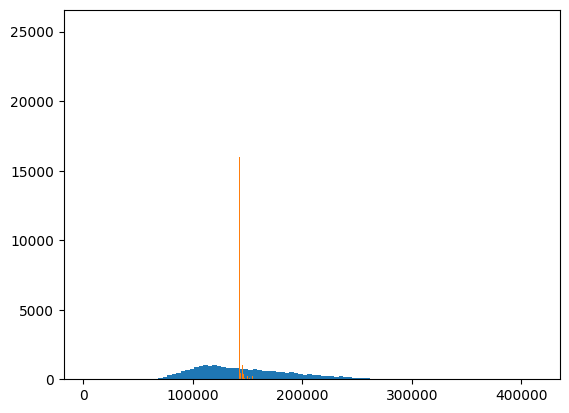

In [33]:
from matplotlib import pyplot as plt
from InitialProject.dataset import ParticleDataset

test_data = ParticleDataset(path=f"{DATA_DIR}/test",
                            variables_path=f"{DATA_DIR}/regression_variables.txt",
                            target="ALL")
test_data = test_data[:][0]

nn_predicted_vals = pd.Series(nn_model(test_data).detach().numpy().reshape(-1))
cat_predicted_vals = pd.Series(cat.predict(test_data.detach().numpy()))
lgbm_predicted_vals = pd.Series(lgbm_reg.predict(test_data.detach().numpy()))

print(nn_predicted_vals.head(25))
print(cat_predicted_vals.head(25))

# plt.hist(all_data.reverse_transform(lgbm_predicted_vals), bins=100)
plt.hist(all_data.reverse_transform(val_targets), bins=100)
plt.hist((cat_predicted_vals), bins=100)
# plt.hist(all_data.reverse_transform(nn_predicted_vals), bins=100)
plt.show()


In [29]:
cat.fit(train_features.detach().numpy(), all_data.reverse_transform(train_targets.detach().numpy()))
lgbm_reg.fit(train_features.detach().numpy(), all_data.reverse_transform(train_targets.detach().numpy()))

[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.747416362380328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.747416362380328
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMRegressor(bagging_fraction=0.2, bagging_freq=1,
              feature_fraction=0.30000000000000004, lambda_l1=20, lambda_l2=65,
              learning_rate=0.13385944399905167, max_bin=242, max_depth=8,
              metric='l1', min_data_in_leaf=10000,
              min_gain_to_split=13.747416362380328, n_estimators=10000,
              num_leaves=2860)

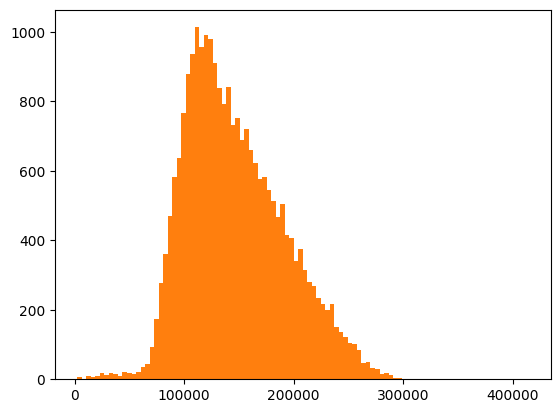

In [47]:
from sklearn.preprocessing import RobustScaler, StandardScaler

scaler_x = RobustScaler(quantile_range=[10, 90]).fit(all_data[:][0])
scaler_y = StandardScaler().fit(all_data[:][1].reshape(-1, 1))

feat_trans = scaler_x.transform(all_data[:][0])
target_trans = scaler_y.transform(all_data[:][1].reshape(-1, 1))

cat_default = CatBoostRegressor(
    verbose=False,
    task_type="GPU",
)
cat_default.fit(train_features.detach().numpy(), np.log(all_data.reverse_transform(train_targets.detach().numpy())))
plt.hist(np.exp(cat_default.predict(val_targets.detach().numpy())), bins=100)
plt.hist(all_data.reverse_transform(val_targets), bins=100)
plt.show()

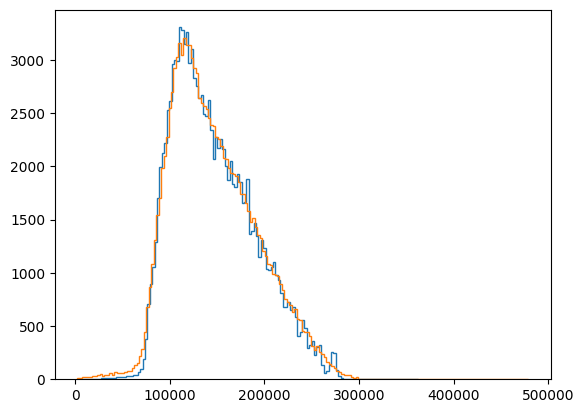

In [44]:
cat_default.fit(X, y)
plt.hist(cat_default.predict(X), bins="auto", histtype="step")
plt.hist(y, bins="auto", histtype="step")
plt.show()

In [53]:
def rel_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred / y_true))

def objective(trial: optuna.Trial, feature_values, target_values, y_scaler, n_splits=3) -> float:
    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "verbose": False,
        "task_type": "GPU",
    }
    cat_reg = CatBoostRegressor(**params)
    total_rel_mae = 0.
    skf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, val_index in skf.split(feature_values, target_values):
        X_train = feature_values[train_index]
        X_val = feature_values[val_index]
        y_train = target_values[train_index]
        y_val = target_values[val_index]
        cat_reg.fit(X_train, y_train)
        total_rel_mae += rel_mae(y_scaler.inverse_transform(y_val.reshape(-1, 1)), y_scaler.inverse_transform(cat_reg.predict(X_val).reshape(-1, 1)))
    return total_rel_mae / n_splits

cat_study = optuna.create_study(direction="minimize")
optuna.logging.set_verbosity(optuna.logging.INFO)
cat_study.optimize(lambda t: objective(t, np.array(X), np.array(y).reshape(-1, 1), y_scaler=scaler_y), n_trials=100)

[I 2023-05-21 16:02:15,458] A new study created in memory with name: no-name-1a6e9986-9218-4574-9152-a21ff47d8bb0
[I 2023-05-21 16:02:28,822] Trial 0 finished with value: 73285.57118187494 and parameters: {'iterations': 508, 'learning_rate': 0.0067410869723457745, 'depth': 10, 'l2_leaf_reg': 0.005039348352293538, 'bootstrap_type': 'Bayesian', 'random_strength': 2.630385043192741e-06, 'bagging_temperature': 9.513610512848322, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial 0 with value: 73285.57118187494.
[I 2023-05-21 16:02:44,644] Trial 1 finished with value: 73285.57391204627 and parameters: {'iterations': 1168, 'learning_rate': 0.0031006010625699372, 'depth': 8, 'l2_leaf_reg': 0.05107103594964604, 'bootstrap_type': 'Poisson', 'random_strength': 2.1680164554753164e-05, 'bagging_temperature': 5.117092146402564, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial 0 with value: 73285.57118187494.
[I 2023-05-21 16:02:50,349] Trial 2 finished with value: 73285.50407144865 and parame

(array([1.100e+01, 1.500e+01, 1.900e+01, 2.500e+01, 2.200e+01, 2.400e+01,
        2.700e+01, 3.000e+01, 4.400e+01, 4.500e+01, 3.400e+01, 4.100e+01,
        3.900e+01, 6.200e+01, 4.300e+01, 6.600e+01, 6.200e+01, 5.500e+01,
        6.300e+01, 6.500e+01, 7.700e+01, 7.600e+01, 1.040e+02, 1.310e+02,
        1.510e+02, 2.180e+02, 2.890e+02, 4.470e+02, 6.780e+02, 8.680e+02,
        1.083e+03, 1.311e+03, 1.544e+03, 1.698e+03, 1.984e+03, 2.093e+03,
        2.280e+03, 2.552e+03, 2.700e+03, 2.928e+03, 3.031e+03, 3.162e+03,
        3.047e+03, 3.202e+03, 3.139e+03, 3.141e+03, 3.016e+03, 2.925e+03,
        2.877e+03, 2.639e+03, 2.595e+03, 2.568e+03, 2.542e+03, 2.457e+03,
        2.389e+03, 2.382e+03, 2.273e+03, 2.256e+03, 2.193e+03, 2.078e+03,
        2.073e+03, 1.986e+03, 1.936e+03, 1.929e+03, 1.912e+03, 1.849e+03,
        1.738e+03, 1.736e+03, 1.660e+03, 1.585e+03, 1.474e+03, 1.519e+03,
        1.431e+03, 1.354e+03, 1.327e+03, 1.203e+03, 1.162e+03, 1.084e+03,
        1.074e+03, 9.850e+02, 9.800e+0

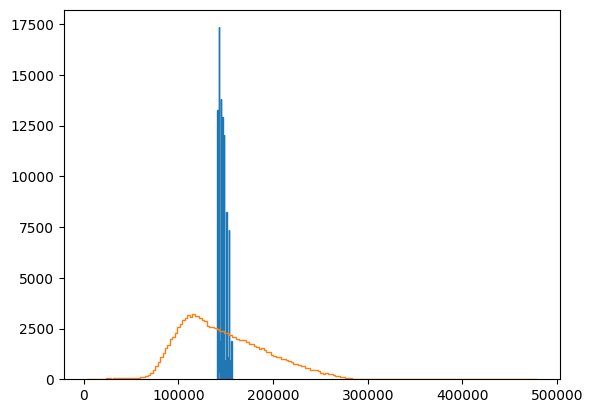

In [55]:
cat_opt = CatBoostRegressor(verbose=False, task_type="GPU", **cat_study.best_params)
cat_opt.fit(X, y)
plt.hist(cat_opt.predict(X), bins="auto", histtype="step")
plt.hist(y, bins="auto", histtype="step")

In [62]:
print(rel_mae(y, cat_opt.predict(X)))
print(rel_mae(np.array(y).reshape(-1, 1), scaler_y.inverse_transform(cat_default.predict(X).reshape(-1, 1))))

146572.0962164341
146573.20878365193


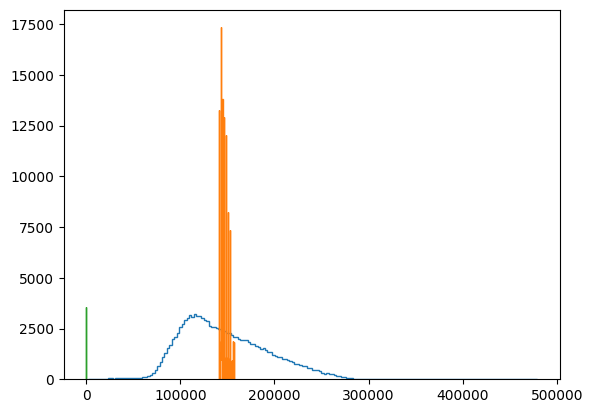

In [65]:
plt.hist(y, bins="auto", histtype="step")
plt.hist(cat_opt.predict(X), bins="auto", histtype="step")
plt.hist(scaler_y.inverse_transform(cat_default.predict(X).reshape(-1, 1)), bins="auto", histtype="step")
plt.show()